# PCA on MNIST dataset

In [28]:
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA as SKPCA

### Load Data

In [29]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
print("X_train: " + str(X_train.shape))
print("Y_train: " + str(Y_train.shape))
print("X_test: " + str(X_test.shape))
print("Y_test: " + str(Y_test.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test: (10000, 28, 28)
Y_test: (10000,)


### Reshape

In [30]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

print("X_train: " + str(X_train.shape))
print("Y_train: " + str(Y_train.shape))
print("X_test: " + str(X_test.shape))
print("Y_test: " + str(Y_test.shape))


X_train: (60000, 784)
Y_train: (60000,)
X_test: (10000, 784)
Y_test: (10000,)


### Normalize

In [31]:
mu = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
std_filled = std.copy()
std_filled[std==0] = 1.

X_train = (X_train - mu)/std_filled 
X_test =  (X_test - mu)/std_filled 
Y_train = Y_train.astype(np.int32)
Y_test = Y_test.astype(np.int32)


### One-hot representation

In [32]:
Y_train = tf.keras.utils.to_categorical(Y_train, 10)
Y_test = tf.keras.utils.to_categorical(Y_test, 10)

In case of memory allocation issues, use a subset of trainig data

In [33]:
X = X_train[0:60000,:]
Y = Y_train[0:60000,:]

print("X: " + str(X.shape))
print("Y: " + str(Y.shape))

X: (60000, 784)
Y: (60000, 10)


In [34]:
def show_sample(X, Y, index):
	image = np.reshape(X[index], (28, 28))
	labels = Y[index]
	print ("Number: " + str(np.argmax(labels)))
	plt.imshow(image)
	plt.show()

Number: 3


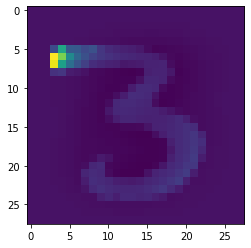

In [35]:
show_sample(X, Y, 12)

### Compute the Covariance Matrix

In [36]:
S = np.cov(X, rowvar=False, bias=True)
print("Covariance Matrix: " + str(S.shape))

Covariance Matrix: (784, 784)


### Compute Eigenvalues and Eigenvectors from Covariance Matrix

In [37]:
eigenvalues, eigenvectors = np.linalg.eigh(S)

In [38]:
print("eigenvalues: " + str(eigenvalues.shape))
print("eigenvectors: " + str(eigenvectors.shape))

eigenvalues: (784,)
eigenvectors: (784, 784)


### Sort Eigenvalues and Eigenvectors descending

In [39]:
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

### Top 5 Eigenvalues

In [40]:
eigenvalues[0:5]

array([40.48696031, 29.24121016, 26.81135762, 20.68627344, 18.07634885])

### Take Principal Components

In [41]:
num_components = 20
B = eigenvectors[:,:num_components] # futures vector
print("B: " + str(B.shape))


B: (784, 20)


### Reduced data

In [42]:
X_reduced = X@B
print("X_reduced: " + str(X_reduced.shape))


X_reduced: (60000, 20)


### Compute the projection matrix

In [43]:
P = B@(np.linalg.inv(B.T@B))@B.T
print("P: " + str(P.shape))

P: (784, 784)


### Reconstruct the data

In [44]:
X_reconstructed = (P@X.T).T
print("X_reconstructed: " + str(X_reconstructed.shape))

X_reconstructed: (60000, 784)


Number: 3


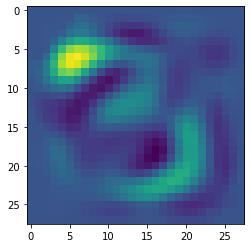

In [45]:
show_sample(X_reconstructed, Y, 12)

### PCA using sklearn

In [46]:

pca = SKPCA(n_components=num_components, svd_solver='full')
sklearn_reduced = pca.fit_transform(X)
sklearn_reconst = pca.inverse_transform(sklearn_reduced)
print("sklearn_reduced: " + str(sklearn_reduced.shape))
print("sklearn_reconst: " + str(sklearn_reconst.shape))
#np.testing.assert_almost_equal(sklearn_reconst, X_reconstructed)


sklearn_reduced: (60000, 20)
sklearn_reconst: (60000, 784)


Number: 3


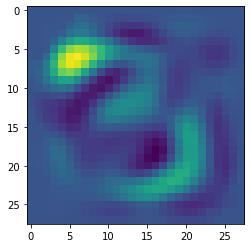

In [47]:
show_sample(sklearn_reconst, Y, 12)

### Create the Model

In [48]:
def create_model(features, classes):
    model = keras.Sequential()
    model.add(keras.Input(shape=(features, ), name='input'))
    model.add(keras.layers.Dense(32, activation='relu', name='h1'))
    model.add(keras.layers.Dense(32, activation='relu', name='h2'))
    model.add(keras.layers.Dense(classes, activation='softmax', name='output'))

    return model


In [49]:
model = create_model(num_components, 10)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 32)                672       
                                                                 
 h2 (Dense)                  (None, 32)                1056      
                                                                 
 output (Dense)              (None, 10)                330       
                                                                 
Total params: 2,058
Trainable params: 2,058
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [50]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(),
    metrics=['accuracy']
)

history = model.fit(
    X_reduced, 
    Y, 
    batch_size=128, 
    epochs=50, 
    validation_split=0.2, 
    verbose=1)

Epoch 1/50
375/375 [==============================] - 3s 5ms/step - loss: 0.7403 - accuracy: 0.7685 - val_loss: 0.3506 - val_accuracy: 0.8895
Epoch 2/50
375/375 [==============================] - 2s 4ms/step - loss: 0.3262 - accuracy: 0.8982 - val_loss: 0.2761 - val_accuracy: 0.9117
Epoch 3/50
375/375 [==============================] - 2s 4ms/step - loss: 0.2694 - accuracy: 0.9161 - val_loss: 0.2383 - val_accuracy: 0.9245
Epoch 4/50
375/375 [==============================] - 2s 4ms/step - loss: 0.2397 - accuracy: 0.9253 - val_loss: 0.2189 - val_accuracy: 0.9287
Epoch 5/50
375/375 [==============================] - 2s 4ms/step - loss: 0.2209 - accuracy: 0.9316 - val_loss: 0.2066 - val_accuracy: 0.9333
Epoch 6/50
375/375 [==============================] - 2s 4ms/step - loss: 0.2074 - accuracy: 0.9354 - val_loss: 0.1961 - val_accuracy: 0.9362
Epoch 7/50
375/375 [==============================] - 2s 4ms/step - loss: 0.1967 - accuracy: 0.9380 - val_loss: 0.1926 - val_accuracy: 0.9388
Epoch 

### Plot

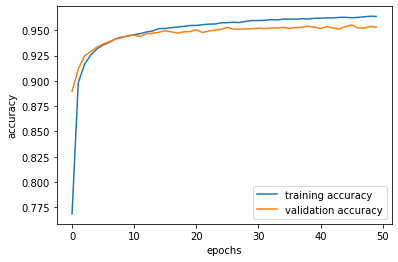

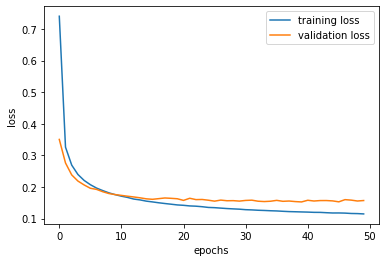

In [51]:
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Evaluate

In [52]:
X_test_reduced = X_test@B
score = model.evaluate(X_test_reduced, Y_test, batch_size=128, verbose=1)

print("Test score: ", score[0])
print("Test accuracy: ", score[1])

79/79 [==============================] - 0s 3ms/step - loss: 0.1656 - accuracy: 0.9508
Test score:  0.16558486223220825
Test accuracy:  0.9508000016212463


### Make a prediction

In [53]:
index = 454
test = np.reshape(X_test_reduced[index], (1, num_components))
prediction = model.predict(test)
expected = Y_test[index]

print("Prediction: ", np.argmax(prediction))
print("Expected: ", np.argmax(expected))

Prediction:  9
Expected:  9
